# N-BEATS 

In [2]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 25.7 MB/s eta 0:00:0000:0100:01


  Using cached fugue_sql_antlr-0.1.8-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 11.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 4.5 MB/s eta 0:00:00
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.3/814.3 kB 15.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 15.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.3/450.3 kB 8.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 MB 13.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = (9,6)

In [6]:
df = pd.read_csv('data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['Temp'], fill_missing_dates=True, freq='d')

<Axes: xlabel='Date'>

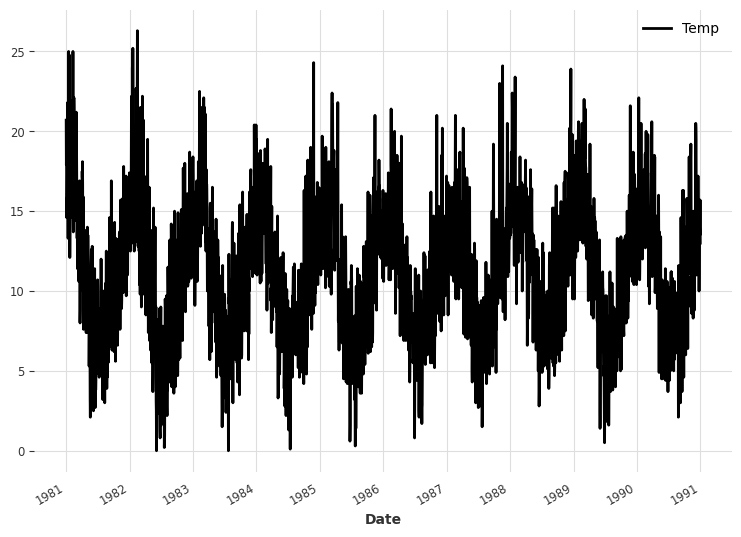

In [9]:
series.plot()

In [10]:
print(len(series))
print(len(df))

3652
3650


In [11]:
from darts.utils.missing_values import fill_missing_values

full_series = fill_missing_values(series)

## Train/test split 

<Axes: xlabel='Date'>

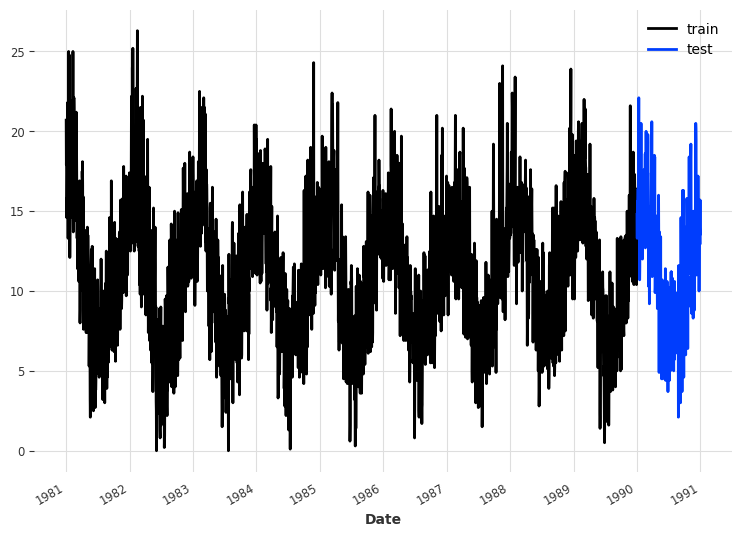

In [12]:
train, test = full_series[:-365], full_series[-365:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [13]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=365)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(365)

Importing plotly failed. Interactive plots will not work.


<Axes: xlabel='Date'>

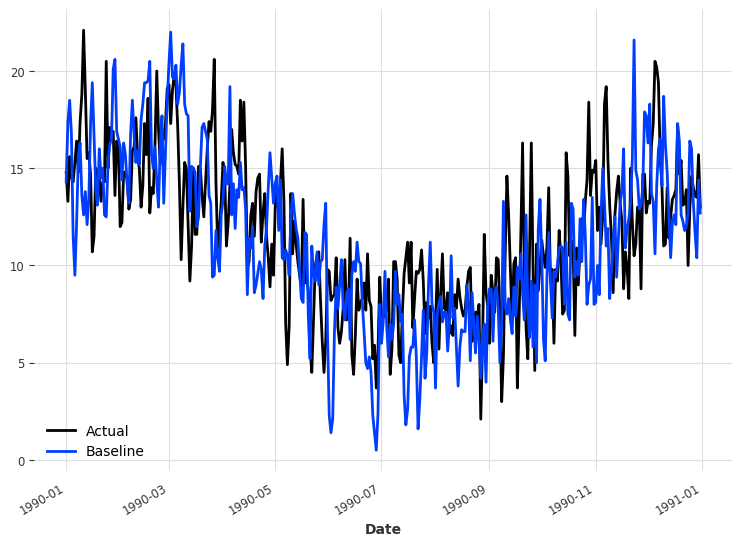

In [14]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')

## N-BEATS 

In [ ]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nbeats = NBEATSModel(
    input_chunk_length=365, 
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42)

nbeats.fit(
    scaled_train,
    epochs=15
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
scaled_pred_nbeats = nbeats.predict(n=365)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

### Evaluation 

In [ ]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)
nbeats_mae = mae(test, pred_nbeats)

In [ ]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS']
y = [naive_mae, nbeats_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

In [ ]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')
pred_nbeats.plot(label='N-BEATS')

## N-BEATS with covariates 

In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = dt_attr(series.time_index, 'month', dtype=np.float32)

In [ ]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_scaled_cov = scaled_cov[:-365], scaled_cov[-365:]

In [ ]:
scaled_cov.plot()

In [ ]:
nbeats_cov = NBEATSModel(
    input_chunk_length=365, 
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=15
)

In [ ]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=365)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

### Evaluation 

In [ ]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

In [ ]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS', 'N-BEATS+cov']
y = [naive_mae, nbeats_mae, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

In [ ]:
test.plot(label='Actual')
pred_nbeats_cov.plot(label='N-BEATS+cov')
pred_nbeats.plot(label='N-BEATS')